In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2
from skimage import io
from skimage.transform import resize
import h5py
from skimage import color

In [3]:
def qpie_encoding(image_data):
    n = int(np.log2(image_data.size))

    amplitudes = image_data.flatten()
    amplitudes = amplitudes/np.linalg.norm(amplitudes) #normalize coefficients
    return amplitudes, n

10


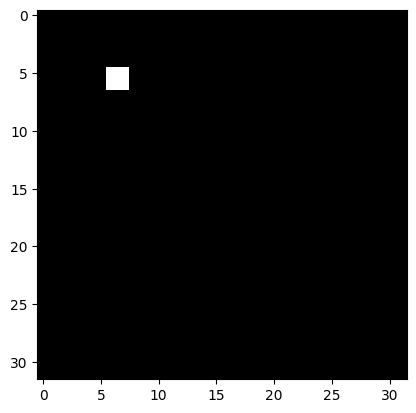

In [4]:
img = np.zeros((32,32))
img[5,6] = 1
img[6,6] = 1
img[5,7] = 1
img[6,7] = 1
plt.imshow(img,cmap='gray')

amp, n = qpie_encoding(img)
print(n)
SHOTS = 1048576
dev1 = qml.device('default.qubit', wires=n, shots=SHOTS)

In [5]:

def circuit(init_value, num_wire, device):
    def inside_circuit():
        qml.QubitStateVector(init_value, wires=range(num_wire))
        return qml.probs()
    return qml.QNode(inside_circuit, device)

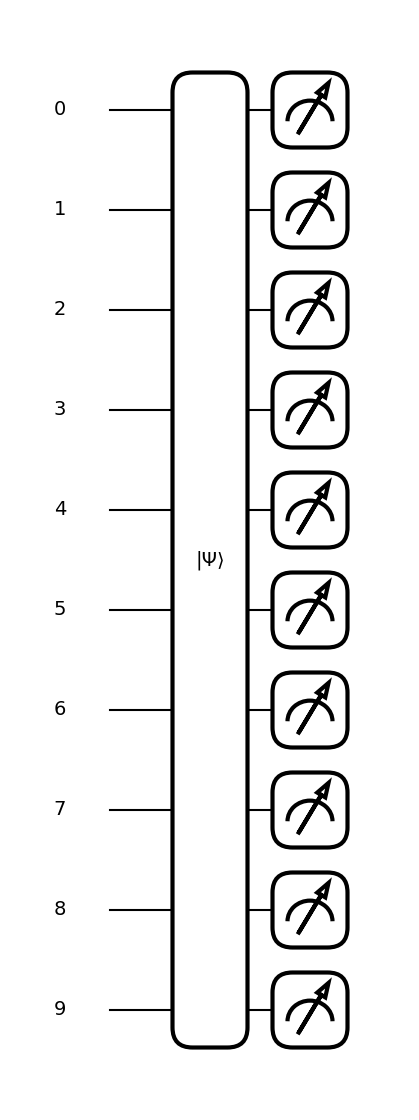

In [6]:
fig, ax = qml.draw_mpl(circuit(amp,n,dev1))()

In [7]:
measured_circuit = circuit(amp,n,dev1)()

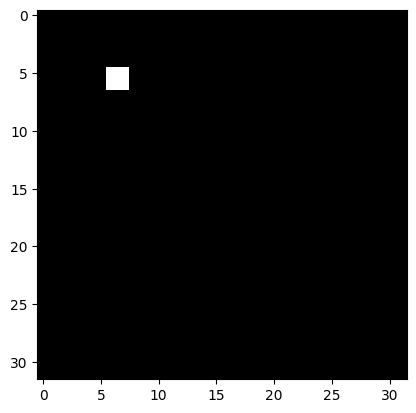

In [8]:
norm = (np.linalg.norm(img.flatten()))
imout = measured_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

In [9]:
def MSE(img1,img2):

    img = (img1-img2)**2
    s = np.sum(img.flatten())/(len(img1**2))

    return s

In [10]:
MSE(img,imout)

0.07031251026825203

10
muh wires : [0, 1, 2, 3, 4]
meh wires : [5, 6, 7, 8, 9]
[4.04129079 3.96764256 3.92706952 ... 3.78008763 3.90762476 3.94542853]


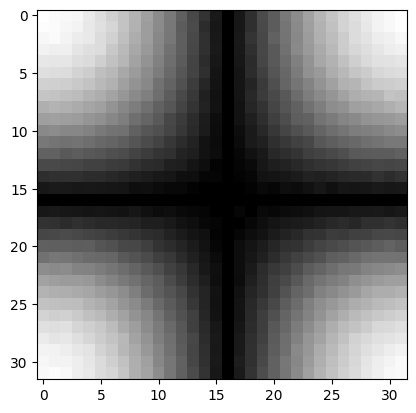

In [11]:
def qft_circuit(init_value,num_wire,device):
    @qml.qnode(device)
    def inside_circuit():
        qml.QubitStateVector(init_value, wires=range(num_wire))
        print(num_wire)
        print(f"muh wires : {[i for i in range(int(num_wire/2))]}")
        print(f"meh wires : {[i+int(num_wire/2) for i in range(int(num_wire/2))]}")
        qml.QFT(wires=[i for i in range(int(num_wire/2))])
        qml.QFT(wires=[i+int(num_wire/2) for i in range(int(num_wire/2))])
        return qml.probs()
    return qml.QNode(inside_circuit, device)

measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev1)()) * norm * 2**(n/2)
print(measured_qft_circuit)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

10
muh wires : [0, 1, 2, 3, 4]
meh wires : [5, 6, 7, 8, 9]


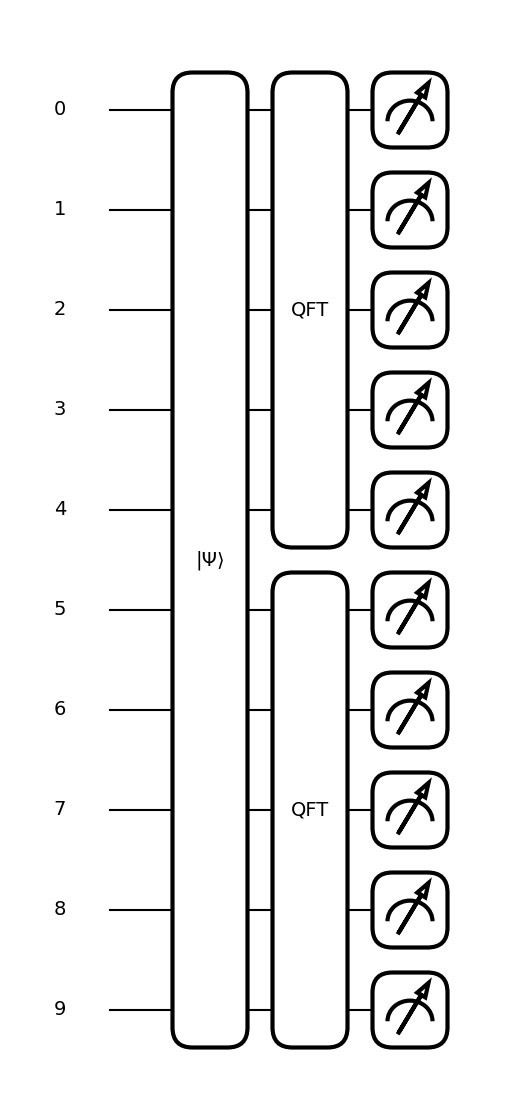

In [12]:
fig, ax = qml.draw_mpl(qft_circuit(amp,n,dev1))()

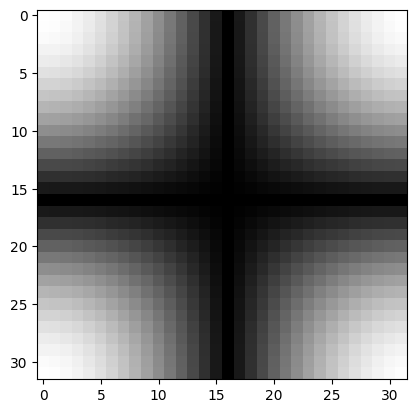

In [13]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [14]:
MSE(imout,np.abs(ft))

0.028492712020003565

10
muh wires : [0, 1, 2, 3, 4]
meh wires : [5, 6, 7, 8, 9]


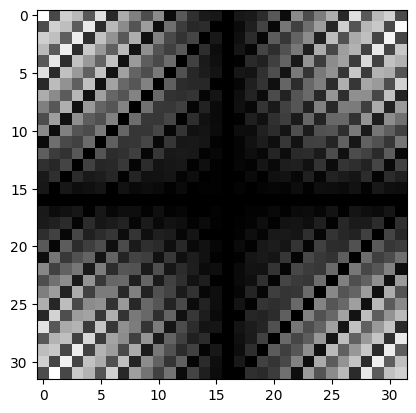

In [15]:
img = np.zeros((32,32))
img[5,6] = 1
img[6,6] = 1
img[5,7] = 1
img[6,7] = 1
img[24,25] = 1
img[25,25] = 1
img[24,26] = 1
img[25,26] = 1
amp, n = qpie_encoding(img)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev1)()) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

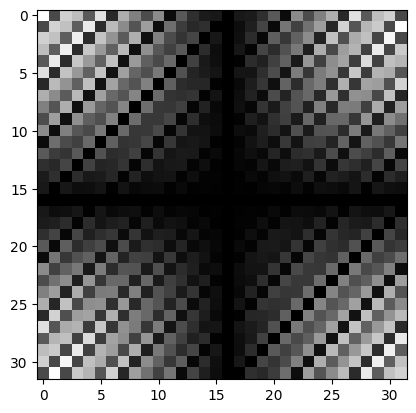

In [16]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [17]:
MSE(imout,np.abs(ft))

0.058374410318450344

10
muh wires : [0, 1, 2, 3, 4]
meh wires : [5, 6, 7, 8, 9]


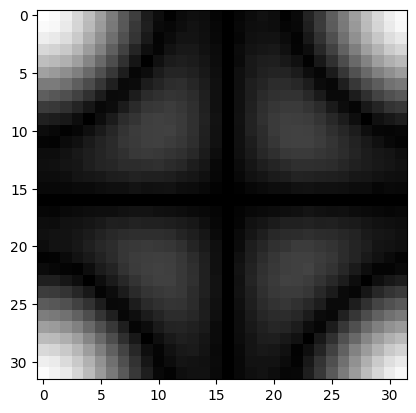

In [18]:
img = np.zeros((32,32))
img[4,4]=1
img[4,5]=1
img[5,4]=1
img[5,5]=1
img[6,4]=1
img[6,5]=1
img[7,4]=1
img[7,5]=1
img[5,3]=1
img[6,3]=1
img[5,5]=1
img[6,6]=1
img[5,6]=1
amp, n = qpie_encoding(img)
norm = (np.linalg.norm(img.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev1)()) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

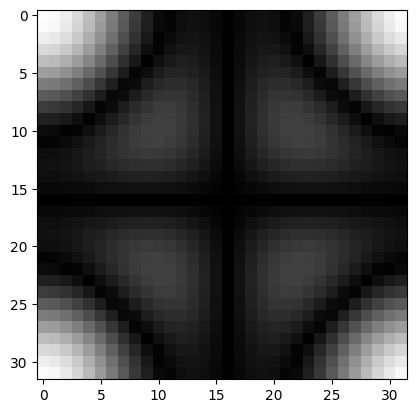

In [19]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [20]:
MSE(imout,np.abs(ft))

0.09147103217975953

12
12
muh wires : [0, 1, 2, 3, 4, 5]
meh wires : [6, 7, 8, 9, 10, 11]


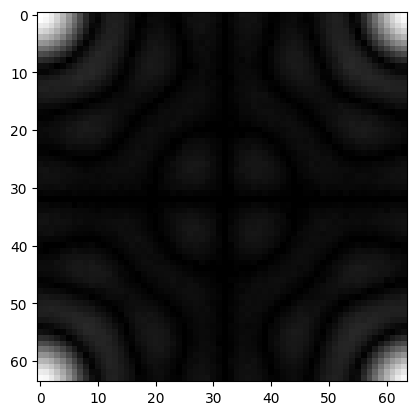

In [21]:
img = np.zeros((64,64))
img[10:14,10:18] =1
img[9,11:17]=1
img[8,12:16]=1
img[14,11:17]=1
img[15,12:16]=1
norm = (np.linalg.norm(img.flatten()))

amp, n = qpie_encoding(img)

print(n)

dev2 = qml.device('default.qubit', wires=n, shots=SHOTS)
measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev2)()) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(img.shape)
plt.imshow(imout,cmap='gray')

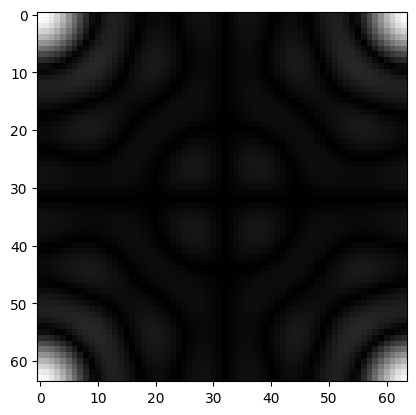

In [22]:
ft = fft2(img)
plt.imshow(np.abs(ft),cmap='gray')

In [23]:
MSE(imout,np.abs(ft))

3.353377230144226

In [27]:
# reconstruction du code de qiskit du papier 1 pour 1 en pennylane.
def circuit_counts(init_value, num_wire, device):
    def inside_circuit():
        qml.QubitStateVector(init_value, wires=range(num_wire))
        return qml.counts()
    return qml.QNode(inside_circuit, device)

def decode_out(counts,norm,wires,fourier=False):
    outim = np.zeros((int(2**(n/2)), int(2**(n/2))))

    b = 0
    for i,j in np.ndindex(outim.shape):

        bit = format(b, '0' + str(n) + 'b')
        p_i = counts.get(bit,0)/SHOTS
        
        if fourier:
            pix_val = np.sqrt(p_i) * norm * 2**(n/2)
        else:
            pix_val = np.sqrt(p_i) * norm
            
        outim[i,j] = (pix_val)
        b+=1
    
    return outim

norm : 113.68997207360074
amps : [0.00472561 0.00472561 0.00472561 ... 0.00220759 0.00251803 0.00255252]


0.9176224892274361

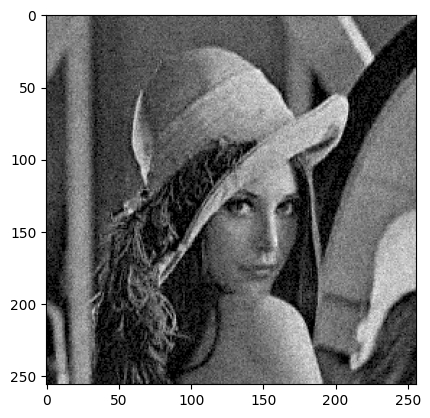

In [68]:
raw_img = io.imread('lena.jpg', as_gray=True)
im = resize(img,(256,256))
norm = (np.linalg.norm(im.flatten()))
print(f"norm : {norm}")

amp, n = qpie_encoding(im)
print(f"amps : {amp}")
dev3 = qml.device('default.qubit', wires=n, shots=SHOTS)
measured_circuit = np.sqrt(circuit(amp,n,dev3)()) * norm
imout = measured_circuit.reshape(im.shape) # prend 0.8 secondes
# measured_circuit = circuit_counts(amp,n,dev3)() 
# imout = decode_out(measured_circuit, norm, n) # prend 21.3 secondes, même erreur que 0.8 secs

plt.figure()
plt.imshow(imout,cmap='gray')
MSE(imout,im)

afin d'avoir une image moin bruité, on va donner 10 fois plus de shots à notre circuit pennylane. la reconstruction d'image de QPIE est probabilistic d'où la raison pourquoi il y a du bruit

0.08151675758953217

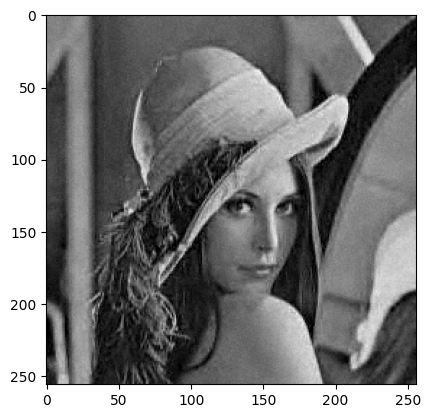

In [70]:

amp, n = qpie_encoding(im)
SHOTS = 1048576*10 # 2**10 * 10
dev3 = qml.device('default.qubit', wires=n, shots=SHOTS)
norm = (np.linalg.norm(im.flatten()))
measured_circuit = np.sqrt(circuit(amp,n,dev3)()) * norm
imout = measured_circuit.reshape(img.shape) # 5.2 secs, MSE : 0.08033409823503883
# measured_circuit = circuit_counts(amp,n,dev3)()
# imout = decode_out(measured_circuit, norm, n) # 3 minutes 6 secs, MSE : 0.0818171451810771
plt.figure()
plt.imshow(imout,cmap='gray')
SHOTS = 1048576

MSE(imout,im)

Appliquons maintenant la transformer de fourier quantique sur l'image :

16
muh wires : [0, 1, 2, 3, 4, 5, 6, 7]
meh wires : [8, 9, 10, 11, 12, 13, 14, 15]


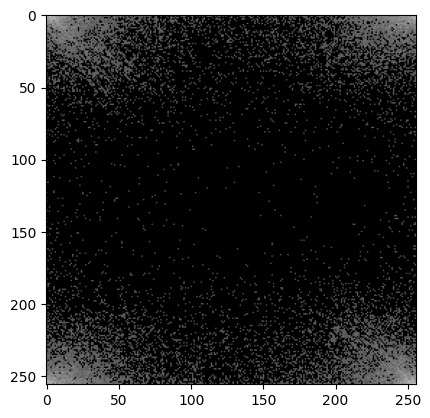

In [80]:
SHOTS = 1048576
dev4 = qml.device('default.qubit', wires=n, shots=SHOTS)
norm = (np.linalg.norm(im.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev4)()) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(im.shape)
plt.figure()
plt.imshow(np.log(imout+1),cmap='gray')

Comparons les résultats d'une transformer de fourier classique sur une image vs transformer de fourier quantique sur une image avec QPIE : 

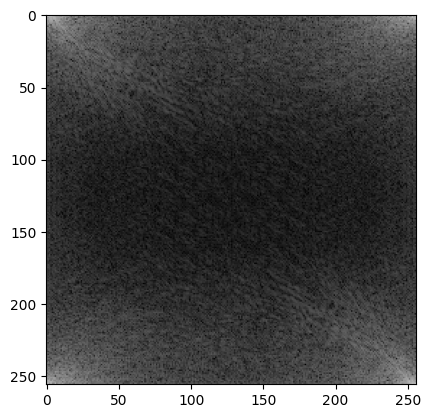

In [81]:
ft = fft2(im)
plt.figure()
plt.imshow(np.log(np.abs(ft)+1),cmap='gray')

In [82]:
MSE(np.log(imout+1),np.log(np.abs(ft)+1)) # l'erreur est moin grande que dans le papier ! meilleur performance !

813.1344517710404

Dans le papier original, cet étape a un MSE de plus de 800 en utilisant le simulateur AER d'IBM, nous avons un MSE comparable de plus de 800 avec le simulateur de pennylane. Plus le chiffre est bas, plus que l'erreur est bas. Donc on préfère avoir un nombre plus petit.
Essayons maintenant avec 100 fois le nombre de shots

16
muh wires : [0, 1, 2, 3, 4, 5, 6, 7]
meh wires : [8, 9, 10, 11, 12, 13, 14, 15]


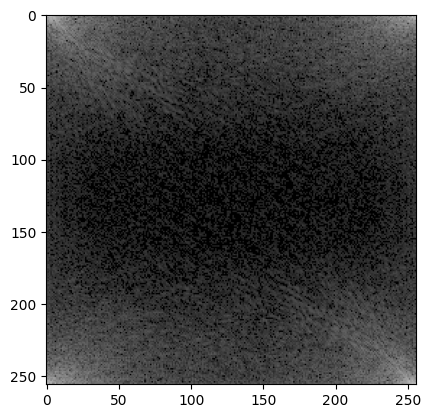

In [83]:
SHOTS = 1048576 * 100
dev4 = qml.device('default.qubit', wires=n, shots=SHOTS)
norm = (np.linalg.norm(im.flatten()))
measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev4)()) * norm * 2**(n/2)
imout = measured_qft_circuit.reshape(im.shape)
SHOTS = 1048576
plt.figure()
plt.imshow(np.log(imout+1),cmap='gray')

In [84]:
MSE(np.log(imout+1),np.log(np.abs(ft)+1))

66.397834200756

Comme attendu, l'erreur on signiticativement diminuer avec plus de shots

In [85]:
shots = [1,10,50,100,200]
MSEs = []
norm = (np.linalg.norm(im.flatten()))
for s in shots:
    SHOTS = s
    dev5 = qml.device('default.qubit', wires=n, shots=SHOTS)
    measured_qft_circuit = np.sqrt(qft_circuit(amp,n,dev5)()) * norm * 2**(n/2)
    imout = measured_qft_circuit.reshape(im.shape)
    MSEs.append(MSE(np.log(imout+1),np.log(np.abs(ft)+1)))
SHOTS = 1048576
plt.plot(shots,MSEs,'bx')
plt.show()

16
muh wires : [0, 1, 2, 3, 4, 5, 6, 7]
meh wires : [8, 9, 10, 11, 12, 13, 14, 15]
